# Forecasting solar flares using support vector machine for classification
***


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, precision_recall_curve, average_precision_score, 
                             fbeta_score, recall_score, make_scorer)

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [2]:
# Load raw dataframe
df = pd.read_csv("../data/data_flares.csv")

print(df.info())
print(df.shape)
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4480 entries, 0 to 4479
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   DATE                        4480 non-null   object 
 1   USFLUX                      4480 non-null   float64
 2   MEANGAM                     4480 non-null   float64
 3   MEANGBT                     4480 non-null   float64
 4   MEANGBZ                     4480 non-null   float64
 5   MEANGBH                     4480 non-null   float64
 6   MEANJZD                     4480 non-null   float64
 7   TOTUSJZ                     4480 non-null   float64
 8   MEANALP                     4480 non-null   float64
 9   MEANJZH                     4480 non-null   float64
 10  TOTUSJH                     4480 non-null   float64
 11  ABSNJZH                     4480 non-null   float64
 12  SAVNCPP                     4480 non-null   float64
 13  MEANPOT                     4480 

# Changing the dataframe to fit SVM
***

In [3]:
# Ensure the 'DATE' column is in datetime format
df['DATE'] = pd.to_datetime(df['DATE'])

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4480 entries, 0 to 4479
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   DATE                        4480 non-null   datetime64[ns, UTC]
 1   USFLUX                      4480 non-null   float64            
 2   MEANGAM                     4480 non-null   float64            
 3   MEANGBT                     4480 non-null   float64            
 4   MEANGBZ                     4480 non-null   float64            
 5   MEANGBH                     4480 non-null   float64            
 6   MEANJZD                     4480 non-null   float64            
 7   TOTUSJZ                     4480 non-null   float64            
 8   MEANALP                     4480 non-null   float64            
 9   MEANJZH                     4480 non-null   float64            
 10  TOTUSJH                     4480 non-null   float64         

In [4]:
# Analyze flare distribution over time
# Number of C, M, and X flares per year

sum_columns = ['Flares: C', 'Flares: M', 'Flares: X']
df_flares = df.groupby(df['DATE'].dt.year)[sum_columns].agg(['sum'])
#df_flares = df_flares.reset_index()
print(df_flares)

# Number of days with M or X flares
yearly_flares = df.groupby(df['DATE'].dt.year)['flare_today'].agg(['sum', 'count', 'mean'])
print("\nDays with M or X flare distribution by year:")
print(yearly_flares)

     Flares: C Flares: M Flares: X
           sum       sum       sum
DATE                              
2010      88.0       8.0       0.0
2011    1199.0     111.0       8.0
2012    1335.0     129.0       7.0
2013    1357.0      99.0      12.0
2014    1798.0     208.0      16.0
2015    1377.0     125.0       2.0
2016     321.0      16.0       0.0
2017     243.0      39.0       4.0
2018      13.0       0.0       0.0
2019      32.0       0.0       0.0
2020      85.0       2.0       0.0
2021     407.0      28.0       2.0
2022    2077.0     184.0       7.0
2023     119.0      23.0       3.0

Days with M or X flare distribution by year:
        sum  count      mean
DATE                        
2010    8.0    245  0.032653
2011   65.0    365  0.178082
2012   79.0    366  0.215847
2013   68.0    365  0.186301
2014  118.0    365  0.323288
2015   68.0    365  0.186301
2016   11.0    366  0.030055
2017   15.0    365  0.041096
2018    0.0    345  0.000000
2019    0.0    273  0.000000
2020    2.0

In [5]:
# function to created the lagged features
def create_lagged_features(df, n_days=3):
    """
    Create features using the last n_days of data to predict the next day's flare.
    """
    df = df.copy()
    df['DATE'] = pd.to_datetime(df['DATE'])
    df = df.sort_values('DATE').reset_index(drop=True)
    
    # Features to use (exclude DATE and target)
    feature_cols = [col for col in df.columns if col not in ['DATE', 'flare_today', 'flare_missing']]
    
    # Create lagged features for each of the past n_days
    lagged_df = pd.DataFrame(index=df.index) # important to keep the index for alignment
    
    for i in range(1, n_days + 1):
        for col in feature_cols:
            lagged_df[f'{col}_lag{i}'] = df[col].shift(i)
    
    # Target: next day's flare (shift flare_today by -1)
    lagged_df['target'] = df['flare_today'].shift(-1)
    lagged_df['DATE'] = df['DATE']
    
    # Drop rows with NaN (first n_days rows and last row)
    lagged_df = lagged_df.dropna()
    
    return lagged_df

In [6]:
# Create the lagged features for the past 3 days
lagged_data = create_lagged_features(df, n_days=3)

print(lagged_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4476 entries, 3 to 4478
Data columns (total 92 columns):
 #   Column                           Non-Null Count  Dtype              
---  ------                           --------------  -----              
 0   USFLUX_lag1                      4476 non-null   float64            
 1   MEANGAM_lag1                     4476 non-null   float64            
 2   MEANGBT_lag1                     4476 non-null   float64            
 3   MEANGBZ_lag1                     4476 non-null   float64            
 4   MEANGBH_lag1                     4476 non-null   float64            
 5   MEANJZD_lag1                     4476 non-null   float64            
 6   TOTUSJZ_lag1                     4476 non-null   float64            
 7   MEANALP_lag1                     4476 non-null   float64            
 8   MEANJZH_lag1                     4476 non-null   float64            
 9   TOTUSJH_lag1                     4476 non-null   float64            
 10  ABSNJ

In [7]:
# chronological split is important for time series
lagged_data = lagged_data.sort_values('DATE').reset_index(drop=True)
assert lagged_data['DATE'].is_monotonic_increasing

print(lagged_data.head())

    USFLUX_lag1  MEANGAM_lag1  MEANGBT_lag1  MEANGBZ_lag1  MEANGBH_lag1  \
0  2.737004e+21     32.654695    114.207593    116.857353     50.317212   
1  3.460735e+21     29.845298    111.707230    113.253585     47.297438   
2  4.497098e+21     32.732238    114.995095    116.684410     53.376813   
3  3.672238e+21     31.230443    121.314292    122.012431     51.513595   
4  3.735080e+21     31.663927    119.169119    119.802653     50.661772   

   MEANJZD_lag1  TOTUSJZ_lag1  MEANALP_lag1  MEANJZH_lag1  TOTUSJH_lag1  ...  \
0      0.219577  3.095129e+12     -0.002852     -0.000701    147.333590  ...   
1      0.145063  3.903967e+12     -0.015477     -0.005461    192.675370  ...   
2      0.285346  5.270056e+12     -0.019851     -0.008012    271.850544  ...   
3      0.013373  4.616568e+12     -0.015028     -0.005155    234.575933  ...   
4      0.018493  4.679853e+12     -0.004378     -0.001769    219.506435  ...   

   xrs_B_max_lag3  Radio Flux 10.7cm_lag3  Sunspot Number_lag3  \
0 

# Fitting the model
***

In [8]:
# let's check all columns to dorp some on the next step
print(lagged_data.columns)

Index(['USFLUX_lag1', 'MEANGAM_lag1', 'MEANGBT_lag1', 'MEANGBZ_lag1',
       'MEANGBH_lag1', 'MEANJZD_lag1', 'TOTUSJZ_lag1', 'MEANALP_lag1',
       'MEANJZH_lag1', 'TOTUSJH_lag1', 'ABSNJZH_lag1', 'SAVNCPP_lag1',
       'MEANPOT_lag1', 'TOTPOT_lag1', 'MEANSHR_lag1', 'SHRGT45_lag1',
       'R_VALUE_lag1', 'xrs_A_mean_lag1', 'xrs_A_min_lag1', 'xrs_A_max_lag1',
       'xrs_B_mean_lag1', 'xrs_B_min_lag1', 'xrs_B_max_lag1',
       'Radio Flux 10.7cm_lag1', 'Sunspot Number_lag1',
       'Sunspot Area (10^6 Hemis.)_lag1', 'New Regions_lag1', 'Flares: C_lag1',
       'Flares: M_lag1', 'Flares: X_lag1', 'USFLUX_lag2', 'MEANGAM_lag2',
       'MEANGBT_lag2', 'MEANGBZ_lag2', 'MEANGBH_lag2', 'MEANJZD_lag2',
       'TOTUSJZ_lag2', 'MEANALP_lag2', 'MEANJZH_lag2', 'TOTUSJH_lag2',
       'ABSNJZH_lag2', 'SAVNCPP_lag2', 'MEANPOT_lag2', 'TOTPOT_lag2',
       'MEANSHR_lag2', 'SHRGT45_lag2', 'R_VALUE_lag2', 'xrs_A_mean_lag2',
       'xrs_A_min_lag2', 'xrs_A_max_lag2', 'xrs_B_mean_lag2', 'xrs_B_min_lag2',
  

In [9]:
# Separate features and target
# I started using the Flares: C/M/X features, and it is very useful, but it may leak information from the future.
# DATE may not be a problem or leak information, but I am excluding it just to be sure
#feature_cols = [col for col in df.columns if col not in ['DATE', 'target']] 
feature_cols = [col for col in lagged_data.columns if col not in [
    'DATE', 
    'target', 
    'flare_missing_lag1',
    'flare_missing_lag2',
    'flare_missing_lag3',
    'Flares: C_lag1', 
    'Flares: M_lag1', 
    'Flares: X_lag1',
    'Flares: C_lag2', 
    'Flares: M_lag2', 
    'Flares: X_lag2',
    'Flares: C_lag3', 
    'Flares: M_lag3', 
    'Flares: X_lag3'
    ]] 
X = lagged_data[feature_cols]
y = lagged_data['target']

print(X.columns)

Index(['USFLUX_lag1', 'MEANGAM_lag1', 'MEANGBT_lag1', 'MEANGBZ_lag1',
       'MEANGBH_lag1', 'MEANJZD_lag1', 'TOTUSJZ_lag1', 'MEANALP_lag1',
       'MEANJZH_lag1', 'TOTUSJH_lag1', 'ABSNJZH_lag1', 'SAVNCPP_lag1',
       'MEANPOT_lag1', 'TOTPOT_lag1', 'MEANSHR_lag1', 'SHRGT45_lag1',
       'R_VALUE_lag1', 'xrs_A_mean_lag1', 'xrs_A_min_lag1', 'xrs_A_max_lag1',
       'xrs_B_mean_lag1', 'xrs_B_min_lag1', 'xrs_B_max_lag1',
       'Radio Flux 10.7cm_lag1', 'Sunspot Number_lag1',
       'Sunspot Area (10^6 Hemis.)_lag1', 'New Regions_lag1', 'USFLUX_lag2',
       'MEANGAM_lag2', 'MEANGBT_lag2', 'MEANGBZ_lag2', 'MEANGBH_lag2',
       'MEANJZD_lag2', 'TOTUSJZ_lag2', 'MEANALP_lag2', 'MEANJZH_lag2',
       'TOTUSJH_lag2', 'ABSNJZH_lag2', 'SAVNCPP_lag2', 'MEANPOT_lag2',
       'TOTPOT_lag2', 'MEANSHR_lag2', 'SHRGT45_lag2', 'R_VALUE_lag2',
       'xrs_A_mean_lag2', 'xrs_A_min_lag2', 'xrs_A_max_lag2',
       'xrs_B_mean_lag2', 'xrs_B_min_lag2', 'xrs_B_max_lag2',
       'Radio Flux 10.7cm_lag2', 'Suns

In [10]:
# Split into train and test sets (chronological split is important for time series)
# Use last 20% as test set
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"\nTraining samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"\nClass distribution in training set:")
print(y_train.value_counts())
print(f"Percentage of positive cases in train: {y_train.mean()*100:.2f}%")
print(f"\nClass distribution in test set:")
print(y_test.value_counts())
print(f"Percentage of positive cases in test: {y_test.mean()*100:.2f}%")


Training samples: 3580
Test samples: 896

Class distribution in training set:
target
0.0    3147
1.0     433
Name: count, dtype: int64
Percentage of positive cases in train: 12.09%

Class distribution in test set:
target
0.0    774
1.0    122
Name: count, dtype: int64
Percentage of positive cases in test: 13.62%


In [11]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
# scoring metric
scoring = make_scorer(fbeta_score, beta=2)

In [13]:
# Use TimeSeriesSplit for cross-validation in time series data
tscv = TimeSeriesSplit(n_splits=5)

In [14]:
# Define the pipeline
# GridSearchCV with balanced and umbalanced data
pipe = Pipeline([
    ("scaler", StandardScaler()),
    #('smote', SMOTE(random_state=42)),
    ("svm", SVC(class_weight='balanced', probability=True, random_state=42))
])

# Define parameter grid
param_grid = [
    {'svm__kernel': ['linear'], 'svm__C': [0.1, 1, 10, 100]},
    {'svm__kernel': ['rbf'], 'svm__C': [0.1, 1, 10, 100], 'svm__gamma': ['scale', 0.01, 0.001]},
    {'svm__kernel': ['poly'], 'svm__C': [0.1, 1, 10, 100], 'svm__gamma': ['scale', 0.01, 0.001]}
]

In [23]:
# you can just load the model if already trained and not run the grid search and best model again
try:
    best_svm = joblib.load("../data/flares_best_SVM.pkl")
except:
    print("No saved model found, proceeding to train a new model.")

In [16]:
# Search for the best hyperparameters
grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=tscv,
    scoring=scoring,
    n_jobs=-1,
    verbose=1
)

print("\nStarting grid search for SVM (this may take a while)...")
grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)


Starting grid search for SVM (this may take a while)...
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Best hyperparameters: {'svm__C': 0.1, 'svm__kernel': 'linear'}
Best cross-validation score: 0.39604700181385455


In [17]:
# Train final model with best parameters on scaled data
best_svm = grid_search.best_estimator_  # pipeline with scaler + best SVM
best_svm.fit(X_train_scaled, y_train)
print(best_svm.named_steps['svm'])

# Save the best model
joblib.dump(best_svm, "../data/flares_best_SVM.pkl")
print("Best model saved to ../data/flares_best_SVM.pkl")

SVC(C=0.1, class_weight='balanced', kernel='linear', probability=True,
    random_state=42)
Best model saved to ../data/flares_best_SVM.pkl


In [18]:
# Make predictions
y_pred = best_svm.predict(X_test_scaled)
y_pred_proba = best_svm.predict_proba(X_test_scaled)[:, 1]

# Results
***

In [19]:
# Evaluation
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

if len(np.unique(y_test)) > 1:
    f2_score = fbeta_score(y_test, y_pred, beta=2)
    f1_score = fbeta_score(y_test, y_pred, beta=1)
    recall = recall_score(y_test, y_pred)
    avg_precision = average_precision_score(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"Average F2 Score: {f2_score:.4f}")
    print(f"Average F1 Score: {f1_score:.4f}")
    print(f"Average Recall Score: {recall:.4f}")
    print(f"Average Precision Score: {avg_precision:.4f}")
    print(f"ROC-AUC Score: {roc_auc:.4f}")


Confusion Matrix:
[[639 135]
 [ 42  80]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.83      0.88       774
         1.0       0.37      0.66      0.47       122

    accuracy                           0.80       896
   macro avg       0.66      0.74      0.68       896
weighted avg       0.86      0.80      0.82       896

Average F2 Score: 0.5690
Average F1 Score: 0.4748
Average Recall Score: 0.6557
Average Precision Score: 0.4034
ROC-AUC Score: 0.8135


In [20]:
# Analyze different classification thresholds
print("\nThreshold Analysis:")

thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
for thresh in thresholds:
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)
    cm_thresh = confusion_matrix(y_test, y_pred_thresh)
    tn, fp, fn, tp = cm_thresh.ravel() if cm_thresh.size == 4 else (cm_thresh[0,0], 0, 0, 0)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    print(f"\nThreshold = {thresh}")
    print(f"  TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")
    print(f"  Precision: {precision:.3f}, Recall: {recall:.3f}")


Threshold Analysis:

Threshold = 0.3
  TP: 34, FP: 41, TN: 733, FN: 88
  Precision: 0.453, Recall: 0.279

Threshold = 0.4
  TP: 22, FP: 21, TN: 753, FN: 100
  Precision: 0.512, Recall: 0.180

Threshold = 0.5
  TP: 13, FP: 10, TN: 764, FN: 109
  Precision: 0.565, Recall: 0.107

Threshold = 0.6
  TP: 7, FP: 6, TN: 768, FN: 115
  Precision: 0.538, Recall: 0.057

Threshold = 0.7
  TP: 2, FP: 5, TN: 769, FN: 120
  Precision: 0.286, Recall: 0.016



Visualization saved as 'solar_flare_SVM_results.png'


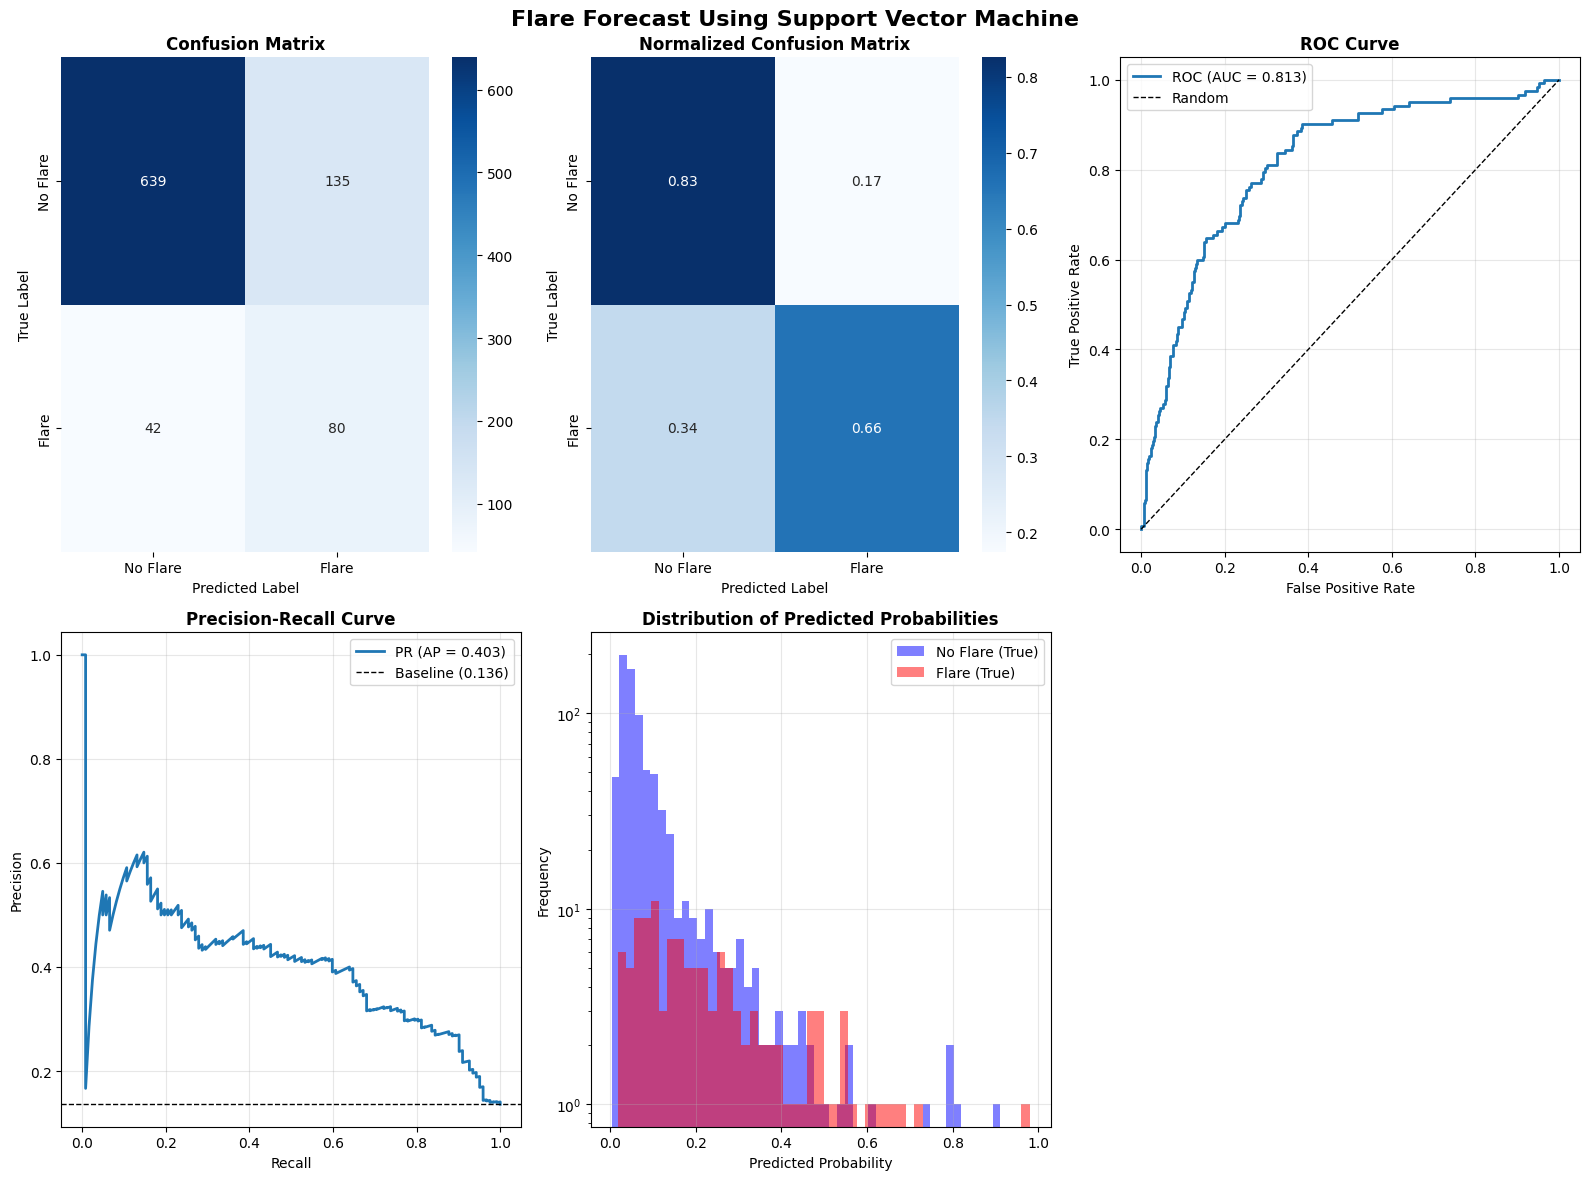

In [21]:
# Visualizations

fig = plt.figure(figsize=(16, 12))
plt.suptitle('Flare Forecast Using Support Vector Machine', fontsize=16, fontweight='bold')

class_names = ['No Flare', 'Flare']

# 1. Confusion Matrix
ax1 = plt.subplot(2, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, xticklabels=class_names, yticklabels=class_names)
ax1.set_title('Confusion Matrix', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')

# 2. Normalized Confusion Matrix
cm_norm = pd.DataFrame(cm).apply(lambda x: x/sum(x), axis = 1)
ax2 = plt.subplot(2, 3, 2)
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap='Blues', ax=ax2, xticklabels=class_names, yticklabels=class_names)
ax2.set_title('Normalized Confusion Matrix', fontsize=12, fontweight='bold')
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')

# 3. ROC Curve
if len(np.unique(y_test)) > 1:
    ax3 = plt.subplot(2, 3, 3)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    ax3.plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {roc_auc:.3f})')
    ax3.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
    ax3.set_xlabel('False Positive Rate')
    ax3.set_ylabel('True Positive Rate')
    ax3.set_title('ROC Curve', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

# 4. Precision-Recall Curve
if len(np.unique(y_test)) > 1:
    ax4 = plt.subplot(2, 3, 4)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    ax4.plot(recall, precision, linewidth=2, label=f'PR (AP = {avg_precision:.3f})')
    ax4.axhline(y=y_test.mean(), color='k', linestyle='--', linewidth=1, 
                label=f'Baseline ({y_test.mean():.3f})')
    ax4.set_xlabel('Recall')
    ax4.set_ylabel('Precision')
    ax4.set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

# 6. Prediction Probability Distribution
ax6 = plt.subplot(2, 3, 5)
ax6.hist(y_pred_proba[y_test == 0], bins=50, alpha=0.5, label='No Flare (True)', color='blue')
ax6.hist(y_pred_proba[y_test == 1], bins=50, alpha=0.5, label='Flare (True)', color='red')
ax6.set_xlabel('Predicted Probability')
ax6.set_ylabel('Frequency')
ax6.set_yscale('log')
ax6.set_title('Distribution of Predicted Probabilities', fontsize=12, fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/solar_flare_SVM_results.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved as 'solar_flare_SVM_results.png'")
plt.show()